In [ ]:
from google.colab import drive
drive.mount('./gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ./gdrive


In [ ]:
!ls

In [ ]:
cd gdrive/My Drive/skk_CS231_study/

/content/gdrive/My Drive/skk_CS231_study


In [ ]:

import tensorflow as tf
import numpy as np
from keras.layers import Flatten,Dense,Conv2D,MaxPooling2D,Dropout,BatchNormalization
from keras import Sequential
from keras.datasets import cifar10

In [ ]:
import torch
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as dset
# (t_data, t_lab), (test_data, test_lab) = mnist.load_data()

In [ ]:
class FashionMnist(Dataset):
    def __init__(self, data_path, is_train=True):
        filename = os.path.join(data_path, './fashion-mnist_train.csv' if is_train else 'fashion-mnist_test.csv')
        assert os.path.exists(filename), 'File not found error'
        self.is_train = is_train
        self.data = pd.read_csv(filename)
        self.data = self.data.sort_values(by=['label']).to_numpy(dtype=np.float32)
        self.data_y = self.data[:, 0].astype(np.int)
        self.data_x = self.data[:, 1:]
        self.data_shape = (1,28,28)
        self.transform = transforms.Compose(
            [
                # transforms.ToPILImage(),
                #transforms.ToTensor(),
                # transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                # # transforms.RandomHorizontalFlip(p=0.5),
                # transforms.RandomVerticalFlip(p=0.5),
                # transforms.RandomRotation(12),
            ]
        )

    def __len__(self):
        return len(self.data_y)

    def __getitem__(self, index):
        ret_x = np.reshape(self.data_x[index], self.data_shape)
        # if self.is_train: # augmentation
            # ret_x = self.transform(ret_x)
        ret_x = self.transform(ret_x)
        ret_y = self.data_y[index]
        return {
            'data_x': ret_x,
            'data_y': ret_y
        }

In [ ]:

# Dataset Class


# Model Class
class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
    
    def forward(self, tensor):
        return self.block(tensor)
    
class BasicModel(nn.Module):
    def __init__(self, in_channel, num_classes):
        super(BasicModel, self).__init__()
        k = 32
        self.block = nn.Sequential(
            ConvBlock(in_channel, k),
            ConvBlock(k, k*2),
            ConvBlock(k*2, k*4),
            ConvBlock(k*4, k*2)
        )
        self.linear = nn.Linear(k*2, num_classes)
    
    def forward(self, tensor):
        out = self.block(tensor)
        out = out.view(-1, out.size(1))
        return self.linear(out)


In [ ]:
batch_size = 256
epoch = 12
learning_rate = 0.001
in_channel = 1
num_classes = 10
betas = (0.5, 0.999)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataset = FashionMnist('./fashion_mnist', True)
test_dataset = FashionMnist('./fashion_mnist', False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, pin_memory=True, num_workers=4, shuffle=True)
valid_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=False, pin_memory=True,
                            num_workers=4)
model = BasicModel(in_channel=in_channel, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss().to(device) # Binary Cross Entropy Loss
optim = torch.optim.SGD(model.parameters(), lr=0.001)
# optim = torch.optim.Adam(model.parameters(), lr=0.001, betas=betas)
avg_loss_list =[]
avg_acc_list=[]
avg_testloss_list=[]
avg_testacc_list=[]

Train

In [ ]:
def main():
    costs = []
    total_batch = len(train_loader)
    temp_img=[]
    for ep in range(epoch):
        # train
        avg_loss = 0
        avg_acc = 0
        temp_cnt= 0
        count = 0

        total_cost = 0
        for i, batch in enumerate(train_loader):
            optim.zero_grad()
            batch_x = batch['data_x'].to(device)
            batch_y = batch['data_y'].to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            avg_loss += loss.item()
            
            
            # cal accuracy
            _, index = torch.max(outputs, 1)
            avg_acc += (index == batch_y).sum().float() / len(batch_y)
            loss.backward()
            optim.step()
            
            count+=1

            temp_cnt +=1
            if temp_cnt == 512 : break
        avg_loss /= count
        avg_acc /= count
        avg_loss_list.append(avg_loss)
        avg_acc_list.append(avg_acc)

        # valid
        with torch.no_grad():
            avg_test_loss = 0
            avg_test_acc = 0

            count = 0
            model.eval()
            print("진입7")
            # device = torch.device(device + ":0")
            for i, batch in enumerate(valid_loader):
                # print("진입8")
                optim.zero_grad()
                batch_x = batch['data_x'].to(device)
                batch_y = batch['data_y'].to(device)
                output = model(batch_x)

                loss = criterion(output, batch_y)
                avg_test_loss += loss.item()

                # cal accuracy
                _, index = torch.max(output, 1)
                avg_test_acc += (index == batch_y).sum().float() / len(batch_y)
                count += 1

            avg_test_loss /= count
            avg_test_acc /= count
            avg_testloss_list.append(avg_test_loss)
            avg_testacc_list.append(avg_test_acc)
            print("[Epoch:%03d] train loss: %.5f train accuracy: %.4f | valid loss: %.5f valid accuracy: %.4f"
                % (ep+1, avg_loss, avg_acc, avg_test_loss, avg_test_acc))
            
    torch.save(model.state_dict(), './fashion_model')
    print("Training Done.")



if __name__ == "__main__":
    main()
    

진입7
[Epoch:001] train loss: 1.29466 train accuracy: 0.6417 | valid loss: 0.87543 valid accuracy: 0.7600
진입7
[Epoch:002] train loss: 0.66626 train accuracy: 0.7816 | valid loss: 0.57939 valid accuracy: 0.7874
진입7
[Epoch:003] train loss: 0.53455 train accuracy: 0.8121 | valid loss: 0.48942 valid accuracy: 0.8289
진입7
[Epoch:004] train loss: 0.48161 train accuracy: 0.8291 | valid loss: 0.50388 valid accuracy: 0.8092
진입7
[Epoch:005] train loss: 0.44850 train accuracy: 0.8414 | valid loss: 0.43732 valid accuracy: 0.8434
진입7
[Epoch:006] train loss: 0.42757 train accuracy: 0.8483 | valid loss: 0.42834 valid accuracy: 0.8450
진입7
[Epoch:007] train loss: 0.40990 train accuracy: 0.8541 | valid loss: 0.41466 valid accuracy: 0.8511
진입7
[Epoch:008] train loss: 0.39311 train accuracy: 0.8594 | valid loss: 0.38192 valid accuracy: 0.8649
진입7
[Epoch:009] train loss: 0.38306 train accuracy: 0.8629 | valid loss: 0.42968 valid accuracy: 0.8343
진입7
[Epoch:010] train loss: 0.36841 train accuracy: 0.8696 | val

View Acc/Loss Graph

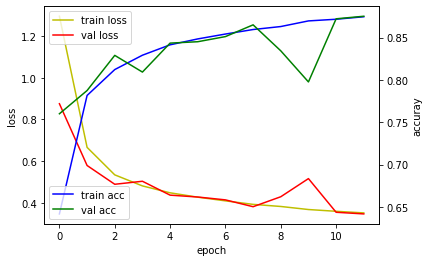

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(avg_loss_list, 'y', label='train loss')
loss_ax.plot(avg_testloss_list, 'r', label='val loss')

acc_ax.plot(avg_acc_list, 'b', label='train acc')
acc_ax.plot(avg_testacc_list, 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
valid_loader_ = DataLoader(test_dataset, batch_size=10000, drop_last=False, pin_memory=True,
                            num_workers=4)
output=[]
origin_pred = []
print(valid_loader.dataset.data_y.shape)
for _,batch in enumerate(valid_loader_):
    
    Y_pred = model(batch['data_x'].to(device))
    # origin_pred = batch['']
    break
# print(valid_loader.dataset.data_y)
# a = tf.convert_to_tensor(valid_loader.dataset.data_x)
# output = model(a)

(10000,)


View Recall / Precision / Micro,Macro Score

In [ ]:
_, index = torch.max(Y_pred, 1)
print(Y_pred.shape)
print(index.shape)

torch.Size([10000, 10])
torch.Size([10000])


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, fbeta_score

print(accuracy_score(valid_loader.dataset.data_y, index))
print(recall_score(valid_loader.dataset.data_y, index,average='micro'))
print(recall_score(valid_loader.dataset.data_y, index,average='macro',))	# 0.42
print(precision_score(valid_loader.dataset.data_y, index,average='micro'))
print(precision_score(valid_loader.dataset.data_y, index,average='macro'))
print(f1_score(valid_loader.dataset.data_y, index,average='micro'))
print(f1_score(valid_loader.dataset.data_y, index,average='macro'))
print(fbeta_score(valid_loader.dataset.data_y,index, beta=5,average='micro'))
print(fbeta_score(valid_loader.dataset.data_y,index, beta=5,average='macro'))

0.8751
0.8751
0.8751000000000001
0.8751
0.8768311570354872
0.8751
0.87505022102918
0.8751000000000001
0.8750327182517855


Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

(10000,)


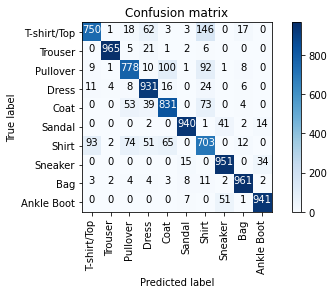

In [ ]:
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred.detach().numpy(),axis = 1) 
# Convert validation observations to one hot vectors
print(Y_pred_classes.shape)
confusion_mtx = confusion_matrix(valid_loader.dataset.data_y, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, 
            classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])

View Correct img / Incorrect img

In [ ]:
# Mapping Classes
clothing = {0 : 'T-shirt/top',
            1 : 'Trouser',
            2 : 'Pullover',
            3 : 'Dress',
            4 : 'Coat',
            5 : 'Sandal',
            6 : 'Shirt',
            7 : 'Sneaker',
            8 : 'Bag',
            9 : 'Ankle boot'}

In [ ]:
#예측이 정확하게 된 경우의 index 4개만 추출(map 보여주기 위해)
correct = []
for i in range(len(valid_loader.dataset.data_y)):
    if(Y_pred_classes[i] == valid_loader.dataset.data_y[i]):
        correct.append(i)
    if(len(correct) == 4):
        break

In [ ]:
print(Y_pred_classes)
print(valid_loader.dataset.data_y)
print(correct)

[0 0 0 ... 7 9 9]
[0 0 0 ... 9 9 9]
[0, 1, 2, 3]


Text(0.5, 1.0, 'Predicted Label : T-shirt/top\nActual Label : T-shirt/top')

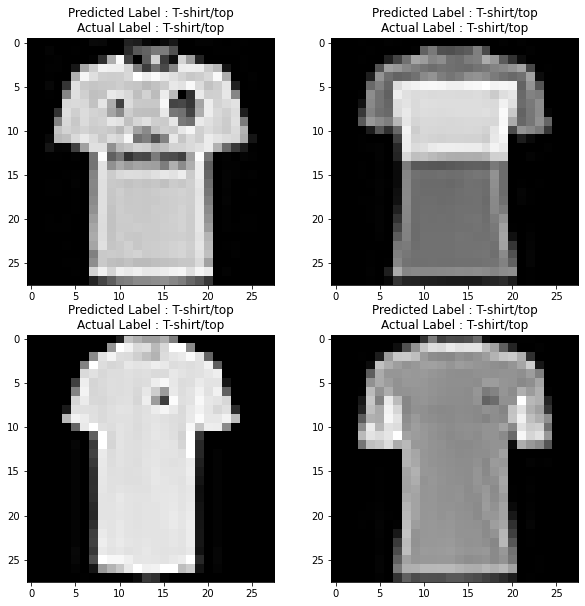

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(12,6))
fig.set_size_inches(10,10)
x_test =valid_loader.dataset.data_x
ax[0,0].imshow(x_test[correct[0]].reshape(28,28), cmap='gray')
ax[0,0].set_title("Predicted Label : " + str(clothing[Y_pred_classes[correct[0]]]) + "\n"+"Actual Label : " + 
                 str(clothing[valid_loader.dataset.data_y[correct[0]]]))
ax[0,1].imshow(x_test[correct[1]].reshape(28,28), cmap='gray')
ax[0,1].set_title("Predicted Label : " + str(clothing[Y_pred_classes[correct[1]]]) + "\n"+"Actual Label : " + 
                 str(clothing[valid_loader.dataset.data_y[correct[1]]]))
ax[1,0].imshow(x_test[correct[2]].reshape(28,28), cmap='gray')
ax[1,0].set_title("Predicted Label : " + str(clothing[Y_pred_classes[correct[2]]]) + "\n"+"Actual Label : " + 
                 str(clothing[valid_loader.dataset.data_y[correct[2]]]))
ax[1,1].imshow(x_test[correct[3]].reshape(28,28), cmap='gray')
ax[1,1].set_title("Predicted Label : " + str(clothing[Y_pred_classes[correct[3]]]) + "\n"+"Actual Label : " + 
                 str(clothing[valid_loader.dataset.data_y[correct[3]]]))